In [740]:
import numpy as np

nn = 1.

def sigm(r,a):
    return 1./(1. + np.exp(-r/a))

def FA(a):
    return np.log(1. + np.exp(a)**nn)
#    return np.sqrt(np.log(1. + np.exp(a)**nn))
#    return np.exp(a)

def dFA(a):
    return nn**(np.exp(a)**nn)/(1. + np.exp(a)**nn)
#    return (nn**(np.exp(a)**nn)/(1. + np.exp(a)**nn))/np.sqrt(np.log(1. + np.exp(a)**nn))
#    return np.exp(a)

def update_a_g(I,ma,mg,Pa,Pg,Fa,Fg,Qa,Qg,R):
    mam = np.dot(Fa,ma)
    mgm = np.dot(Fg,mg)

    Pam = np.dot(np.dot(Fa,Pa),Fa.transpose()) + Qa
    Pgm = np.dot(np.dot(Fg,Pg),Fg.transpose()) + Qg

    err = I - FA(mam)*mgm
    
#    Asam = np.random.multivariate_normal(mam,np.sqrt(Pam),100)
    
#    Ha = np.diag(np.mean(dFA(Asam)*np.expand_dims(mgm,0),axis = 0))
#    Hg = np.diag(np.mean(FA(Asam),axis = 0))
    Ha = dFA(mam)*mgm
    Hg = FA(mam)
   
    Sa = np.dot(Ha,np.dot(Pam,Ha.transpose())) + R
    Sg = np.dot(Hg,np.dot(Pgm,Hg.transpose())) + R

    Ka = np.dot(Pam, np.dot(Ha.transpose(), np.linalg.inv(Sa)))
    Kg = np.dot(Pgm, np.dot(Hg.transpose(), np.linalg.inv(Sg)))
    
    mau = mam + np.dot(Ka,err)
    mgu = mgm + np.dot(Kg,err)

    Pau = np.dot((np.eye(len(ma)) - np.dot(Ka,Ha)),Pam)
    Pgu = np.dot((np.eye(len(mg)) - np.dot(Kg,Hg)),Pgm)
    
    return mau,mgu,Pau,Pgu

def Q_self_con(cov,F):
    return cov - np.dot(np.transpose(F),np.dot(cov,F))

In [783]:
import scipy

Sa = np.array([[1.,1.],[1.,1.]])
Sg = np.array([[1.,.3],[.3,1.]])

dt = .001

Fg = scipy.linalg.expm(dt*np.array([[-1000.,0.],[0.,-1000.]]))
Fa = scipy.linalg.expm((dt*np.array([[0.,0],[0,0.]])))
print(Fg)
print(Fa)

ma = np.array([0.,0.])
mg = np.array([0.,0.])

Qa = Q_self_con(Sa,Fa)
Qg = Q_self_con(Sg,Fg)
print(Qa)

[[ 0.36787944  0.        ]
 [ 0.          0.36787944]]
[[ 1.  0.]
 [ 0.  1.]]
[[ 0.  0.]
 [ 0.  0.]]


In [545]:



def get_resp(taum,Fa,Fg,Qa,Qg):
    cc = np.logspace(0,1.5,20)
    
    T = int(1000)
    ni = int(100)
    nf = int(400)
    
    R = np.array([[1.,0.],[0.,1.]])*taum
    
    MA = [[ma] for i in range(len(cc))]
    MG = [[mg] for i in range(len(cc))]

    PA = [[Sa] for i in range(len(cc))]
    PG = [[Sg] for i in range(len(cc))]

    for i in range(len(cc)):
        meas = np.concatenate([np.zeros([ni,2]),cc[i]*np.ones([T,2]),np.zeros([nf,2])],axis = 0) + np.random.multivariate_normal(np.zeros([2]),R,T+ni+nf)
    
        for k in meas:
            mat,mgt,pat,pgt = update_a_g(k,MA[i][-1],MG[i][-1],PA[i][-1],PG[i][-1],Fa,Fg,Qa,Qg,R)
    
            MA[i].append(mat)
            MG[i].append(mgt)

            PA[i].append(pat)
            PG[i].append(pgt)

    MA = np.array(MA)
    MG = np.array(MG)
    PA = np.array(PA)
    PG = np.array(PG)
    
    return MA,MG,PA,PG

PL = [[get_resp(x,Fa,Fg,Qa,Qg) for k in range(3)] for x in np.logspace(0,2,4)]

(20, 1501, 2)


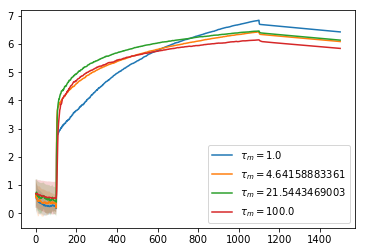

In [546]:
PLm = [[np.mean(np.array([k[b] for k in a]),axis = 0) for b in range(4)] for a in PL]
print(PLm[0][0].shape)

t = np.logspace(0,2,4)

ns = -1

for x in range(len(PLm)):
    plt.plot(range(len(PLm[x][0][ns])),FA(PLm[x][0][ns][:,0]),label = "$\\tau_m = {}$".format(t[x]))
    plt.fill_between(range(len(PLm[x][0][ns])),FA(PLm[x][0][ns][:,0]) - dFA(PLm[x][0][ns][:,0])*np.sqrt(PLm[x][2][ns][:,0,0]),FA(PLm[x][0][ns][:,0]) + dFA(PLm[x][0][ns][:,0])*np.sqrt(PLm[x][2][ns][:,0,0]),alpha = .2)
    
plt.legend()
plt.show()

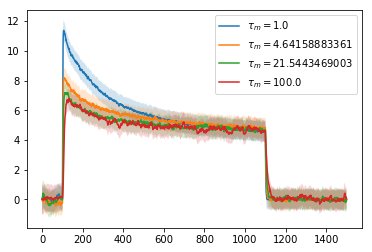

In [547]:
from scipy.ndimage.filters import gaussian_filter as gfilt


for x in range(len(t)):
    plt.plot(range(len(PLm[x][1][ns])),PLm[x][1][ns][:,0],label = "$\\tau_m = {}$".format(t[x]))
    plt.fill_between(range(len(PLm[x][1][ns])),PLm[x][1][ns][:,0] - np.sqrt(PLm[x][3][ns][:,0,0]),PLm[x][1][ns][:,0] + np.sqrt(PLm[x][3][ns][:,0,0]),alpha = .2)

plt.legend()

plt.show()

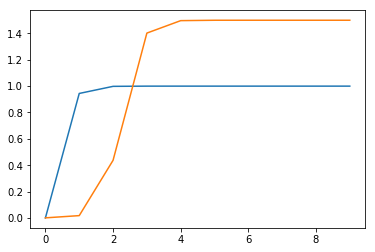

In [731]:
def stim(c,r,w):
    cen = (sigm(r,.25) - .5)*2
    sur = sigm(r - 2,.25)*1.5
    
    out = c * np.array([cen,sur])
    return out

RESP = np.array([stim(1,r,1) for r in np.linspace(0,8,10)])

plt.plot(RESP[:,0])
plt.plot(RESP[:,1])
plt.show()

In [ ]:
def get_resp(taum,Fa,Fg,Qa,Qg,c):
    RESP = c*np.array([stim(1,r,1) for r in np.linspace(0,8,20)])
    
    T = int(1000)
    ni = int(100)
    nf = int(400)
    
    R = np.array([[1.,0.],[0.,1.]])*taum
    
    MA = [[ma] for i in range(len(RESP))]
    MG = [[mg] for i in range(len(RESP))]

    PA = [[Sa] for i in range(len(RESP))]
    PG = [[Sg] for i in range(len(RESP))]

    for i in range(len(RESP)):
        meas = np.concatenate([np.zeros([ni,2]),RESP[i]*np.ones([T,2]),np.zeros([nf,2])],axis = 0) + np.random.multivariate_normal(np.zeros([2]),R,T+ni+nf)
    
        for k in meas:
            mat,mgt,pat,pgt = update_a_g(k,MA[i][-1],MG[i][-1],PA[i][-1],PG[i][-1],Fa,Fg,Qa,Qg,R)
    
            MA[i].append(mat)
            MG[i].append(mgt)

            PA[i].append(pat)
            PG[i].append(pgt)

    MA = np.array(MA)
    MG = np.array(MG)
    PA = np.array(PA)
    PG = np.array(PG)
    
    return MA,MG,PA,PG

PL = [[get_resp(x,Fa,Fg,Qa,Qg,30) for k in range(5)] for x in [5.,10.]]

In [ ]:
GRESP = np.array([[k[1] for k in p] for p in PL])
GR = np.mean(GRESP[:,:,:,200:1000],axis = (1,3))
GR2 = np.mean(GRESP[:,:,:,100:200],axis = (1,3))
RESP = 30*np.array([stim(1,r,1) for r in np.linspace(0,8,10)])
print(GRESP.shape)

plt.plot(GRESP[0,0,-3,:,0],"r")
plt.plot(GRESP[1,0,-3,:,0],"k")

plt.plot(GRESP[0,1,-3,:,0],"r")
plt.plot(GRESP[1,1,-3,:,0],"k")

plt.plot(GRESP[0,2,-3,:,0],"r")
plt.plot(GRESP[1,2,-3,:,0],"k")
plt.show()

plt.plot(GR[0,:,0],label = "A")
plt.plot(GR[1,:,0],label = "Q")
plt.legend()
plt.show()
plt.plot(GR2[0,:,0],label = "A")
plt.plot(GR2[1,:,0],label = "Q")
plt.legend()
plt.show()
plt.plot(RESP[:,0])
plt.plot(RESP[:,1])
plt.show()
print(PL[1][0][1].shape)

In [ ]:
RESP = 100*np.array([stim(1,r,1) for r in np.linspace(0,8,20)])

T = int(1000)
ni = int(100)
nf = int(400)
    

meas = np.array([np.concatenate([np.zeros([ni,2]),RESP[i]*np.ones([T,2]),np.zeros([nf,2])],axis = 0) + np.random.multivariate_normal(np.zeros([2]),R,T+ni+nf) for i in range(len(RESP))])

(20, 1500, 2)


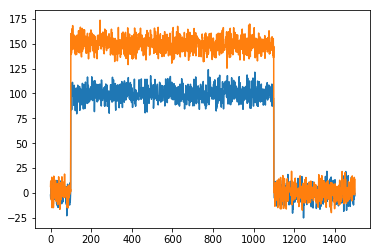

In [782]:
print(meas.shape)
plt.plot(meas[8,:,0])
plt.plot(meas[8,:,1])
plt.show()

In [980]:
import GSM.MGSM_inference as inf
reload(inf) 

<module 'GSM.MGSM_inference' from 'GSM/MGSM_inference.pyc'>

In [1096]:
segs = [[[0],[1]],[[0,1]]]
SG = [[np.array([[1]]),np.array([[1]])],[np.array([[1,.1],[.1,1]])]]

def nSG(snr):
    return [[x/(snr*snr) for x in p] for p in SG]

F = [[np.array([[.6]]),np.array([[.6]])],[np.array([[.6,0],[0,.6]])]]
Q = [[inf.Q_self_con(SG[k][j],F[k][j]) for j in range(len(segs[k]))] for k in range(len(segs))]
print(Q)
P = [.1,.9]
np.linalg.inv(SG[0][0])

[[array([[ 0.64]]), array([[ 0.64]])], [array([[ 0.64 ,  0.064],
       [ 0.064,  0.64 ]])]]


array([[ 1.]])

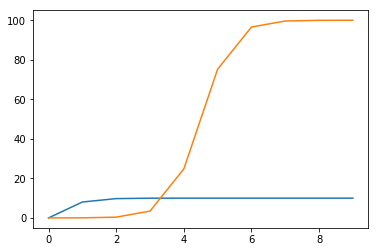

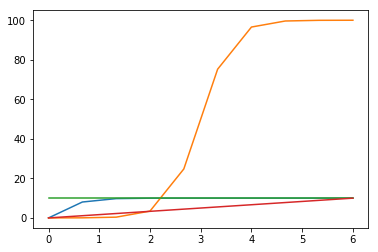

(10, 10, 2)


In [1102]:
def stim(c,r,w):
    cen = (sigm(r,.3) - .5)*2
    sur = 10*sigm(r - 3,.3)
    
    out = c * np.array([cen,sur])
    return out

CC = 10

ii = np.array([[stim(CC,r,1)] for r in np.linspace(0,6,10)])
plt.plot(ii[:,0,0])
plt.plot(ii[:,0,1])
plt.show()

II = ii*np.ones([10,10,2])
II2 = CC*np.ones([2,10,2])*np.array([[[1,0]],[[1,1]]])

plt.plot(np.linspace(0,6,10),II[:,0,0])
plt.plot(np.linspace(0,6,10),II[:,0,1])
plt.plot(np.linspace(0,6,2),II2[:,0,0])
plt.plot(np.linspace(0,6,2),II2[:,0,1])
plt.show()

print(II.shape)

In [1103]:
ind = [0]
seg_index = inf.get_seg_indices(segs,ind)
seg_to_ind = [inf.reverse_indices(np.concatenate([np.array(segs[s][k])[seg_index[s][k]] for k in range(len(seg_index[s]))]),ind) for s in range(len(seg_index))]


segs

#RES=np.array([inf.stable_get_MGSM_att_weights(II,segs,SG,nSG(snr),Q,F,P,seg_index,seg_to_ind)[0] for snr in np.linspace(.1,20,20)])

[[[0], [1]], [[0, 1]]]

In [1104]:
#seg_index
RES=np.array([inf.general_MGSM_g_att(II,segs,SG,nSG(snr),Q,F,P,[0]) for snr in np.logspace(np.log10(.1),np.log10(100),5.)])

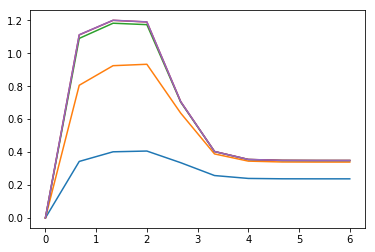

In [1105]:
for s in RES:
    plt.plot(np.linspace(0,6,10),s[:,0])
plt.show()


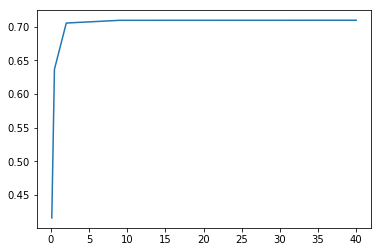

In [1106]:
def SI(x):
    return 1. - (x[-1]/np.max(x))

plt.plot(np.logspace(np.log10(.1),np.log10(40),5.),[SI(s[:,0]) for s in RES])
plt.show()

In [ ]:
C = np.array([[],[]])

In [ ]:
inf.att_egia(n,I,a,cov,ncov,qcov,F,getall = False,getP = False)